In [3]:
# for work with data
import numpy as np
import pandas as pd
# some statistics and modeling
import scipy.stats as ss
from arch import arch_model
# for time estimate
from datetime import datetime, timedelta
# useful for 'for' loops
from itertools import product
# visualization
import matplotlib.pyplot as plt
import seaborn as sns
# financial data
import yfinance as yf

## Preliminary analysis and preprocessing

Let's start from downloading quotes for S&P index and its proxy for trading: S&P 500 (^GSPC) and SPDR S&P 500 ETF Trust (SPY) respectively. Also look at the data and plot the price chart with division into three periods (2010-01-01 : 2018-12-31, 2019-01-01 : 2019-12-31, 2020-01-01 : 2020-09-05).

In [4]:
etf_snp = yf.download('S&P', '2010-01-01', '2020-09-05')
snp_index = yf.download('^GSPC', '2010-01-01', '2020-09-05')
print(etf_snp.shape, snp_index.shape)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
(2688, 6) (2688, 6)


In [5]:
etf_snp.head(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,41.790001,42.990002,41.669998,42.849998,29.852808,35460500
2010-01-05,42.790001,43.840000,42.779999,43.680000,30.431046,41208300
2010-01-06,43.450001,44.090000,43.310001,43.919998,30.598248,27729000


In [6]:
snp_index.head(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.98999,1132.98999,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.52002,1136.52002,2491020000


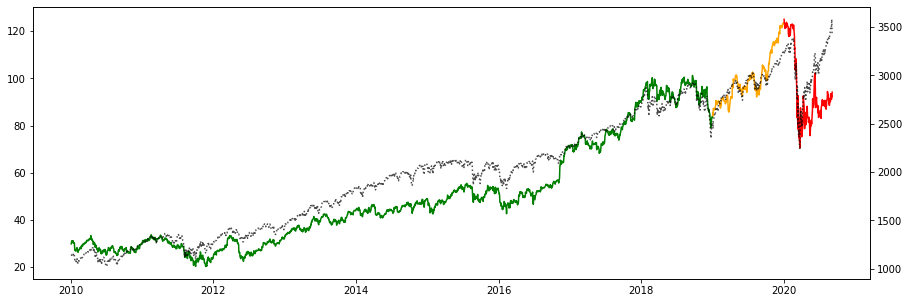

In [7]:
fig, ax1 = plt.subplots(figsize = (15, 5))

ax1.plot(etf_snp['Adj Close'].loc['2010-01-01':'2018-12-31'], c = 'green')
ax1.plot(etf_snp['Adj Close'].loc['2019-01-01':'2019-12-31'], c = 'orange')
ax1.plot(etf_snp['Adj Close'].loc['2020-01-01':'2020-09-05'], c = 'red')

ax2 = ax1.twinx()
ax2.plot(snp_index['Adj Close'], c = 'black', linestyle = ':', alpha = 0.7)

As we expected, lines have almost identical dynamics. Let's transform daily prices to daily returns and plot analogous graph for ETF.

In [8]:
market_return = snp_index['Adj Close'].pct_change().dropna() * 100
market_return = market_return.rename('mark_ret')

snp_return = etf_snp['Adj Close'].pct_change().dropna() * 100
snp_return = snp_return.rename('Returns in %')
snp_return.head(2)

Date
2010-01-05    1.936962
2010-01-06    0.549445
Name: Returns in %, dtype: float64

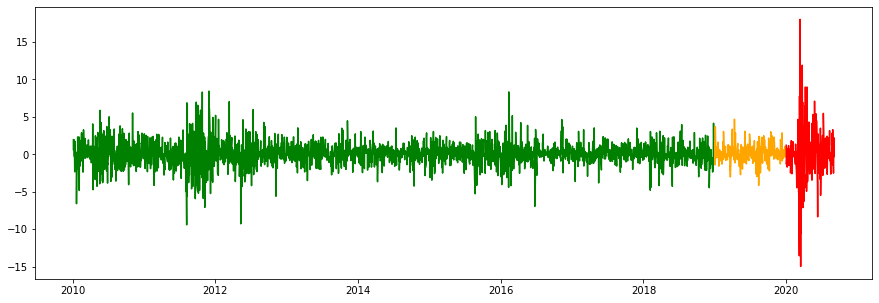

In [9]:
plt.figure(figsize = (15, 5))
plt.plot(snp_return.loc['2010-01-01':'2018-12-31'], c = 'green')
plt.plot(snp_return.loc['2019-01-01':'2019-12-31'], c = 'orange')
plt.plot(snp_return.loc['2020-01-01':'2020-09-05'], c = 'red')

Let's leave only training sample for fitting ARCH model and create new dataframe 'val_and_test' for future backtesting:

In [10]:
train = snp_return.loc['2010-01-01':'2018-12-31']
val_and_test = pd.DataFrame(snp_return)

In [11]:
val_and_test['price'] = etf_snp.loc[:, 'Adj Close']
val_and_test['standard_residuals'] = 0.0

## Choosing the best model

Let's choose the main model for filtering data, using only train data: check different number of lags for autoregressive model (constant mean model is too simple, we will not consider it separately), two variants of volatility processes + their parameters and two distributions for the standardized residuals.

In [12]:
results = {}
for l, m, vol, p, o, q, dist in product([1, 2, 3], ['ARX'], ['EGARCH', 'GARCH'], 
                                        [1, 2], [0, 1, 2], [0, 1, 2], ['skewt', 'ged']):
    am = arch_model(train, mean = m, lags = l, vol = vol, p = p, o = o, q = q, dist = dist)
    res = am.fit(disp = 'off')
    aic, bic = res.aic, res.bic
    results[f'mean: {m}, lags = {l}, vol: {vol}, p = {p}, o = {o}, q = {q}, dist: {dist}'] = \
                                                                                    [round(aic, 4), round(bic, 4)]

In [13]:
[(k, v) for k, v in sorted(results.items(), key = lambda item: item[1][1])][:3]

[('mean: ARX, lags = 1, vol: EGARCH, p = 1, o = 1, q = 1, dist: skewt',
  [7942.0568, 7987.8488]),
 ('mean: ARX, lags = 1, vol: EGARCH, p = 1, o = 2, q = 1, dist: skewt',
  [7938.0531, 7989.5692]),
 ('mean: ARX, lags = 1, vol: EGARCH, p = 1, o = 1, q = 2, dist: skewt',
  [7940.6393, 7992.1554])]

According to BIC, we choose such model: AR(1) + EGARCH(1, 1, 1) + skewstudent distribution.

In [14]:
am = arch_model(train, mean = 'ARX', lags = 1, vol = 'EGARCH', p = 1, o = 1, q = 1, dist = 'skewt')
res = am.fit(disp = 'off')

In [15]:
res.summary

<bound method ARCHModelResult.summary of                                 AR - EGARCH Model Results                                
Dep. Variable:                      Returns in %   R-squared:                       0.003
Mean Model:                                   AR   Adj. R-squared:                  0.003
Vol Model:                                EGARCH   Log-Likelihood:               -3963.03
Distribution:      Standardized Skew Student's t   AIC:                           7942.06
Method:                       Maximum Likelihood   BIC:                           7987.85
                                                   No. Observations:                 2262
Date:                           Sun, Dec 03 2023   Df Residuals:                     2260
Time:                                   14:42:47   Df Model:                            2
                                   Mean Model                                   
                    coef    std err          t      P>|t|       95.0

All parameters have high significant levels. Look, how skew t-distrubution fits our standard residuals: 

In [16]:
val_and_test.loc['2010-01-01':'2018-12-31', 'standard_residuals'] = res.resid / res.conditional_volatility

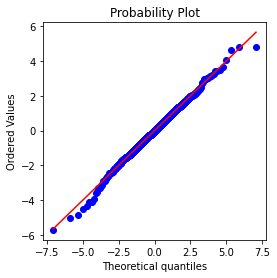

In [17]:
from scipy.stats import nct
plt.figure(figsize = (4, 4))
ss.probplot(np.array(val_and_test.loc['2010-01-01':'2018-12-31', 'standard_residuals'].dropna()), 
            dist = nct(df = res.params[-2], nc = res.params[-1]), plot = plt)
plt.show()

We see some problems with tails, so it is better to use special distributions from Extreme Value Theory for valuating risk metrics. 

However, we will evaluate risk, using empirical quantiles of returns, which we get with our strategy activity. Very soon we will try to use the full model for filtering time series for our trading strategy.

## Metrics and trading strategy

Let's write functions for backtesting/evaluating our future model:

In [18]:
def calculate_VaR(ret, alpha = 0.05):
    return ret.quantile(alpha)

def calculate_ES(ret, alpha = 0.05):
    var = ret.quantile(alpha)
    return ret[ret < var].mean()

def calculate_Sharpe(ret, rf = 0.05):
    r_mean = ret.mean()
    r_vol = ret.std()
    return (r_mean - rf) / r_vol

def calculate_Rachev(ret, alpha = 0.05, beta = 0.10):
    cvar = ret[ret < ret.quantile(alpha)].mean()
    big_profit = ret[ret > ret.quantile(1-beta)].mean()
    return abs(big_profit / cvar)

def calculate_Beta(ret, market_ret):
    return np.cov(ret, market_ret)[1, 0] / np.var(market_ret)

def calculate_maxdrawdown(ret):
    mdd, mdd1, peak, peak1, k = [], 0, [], 0, 0
    
    for i in range(1, len(ret)):
        if (ret[i] > 0) & (ret[i-1] >= 0):
            peak1 = (ret[:(i+1)] / 100 + 1).prod()
        elif (ret[i] < 0) & (ret[i-1] >= 0):
            peak.append((peak1, (k, i)))
            if peak1 == max(peak)[0]:
                k = i
                mdd1 = (ret[k:(i+1)] / 100 + 1).prod()
        elif (ret[i] >= 0) & (ret[i-1] < 0):
            mdd.append((mdd1, (k, i)))
            peak1 = (ret[:(i+1)] / 100 + 1).prod()
        else:
            mdd1 = (ret[k:(i+1)] / 100 + 1).prod()
    
    return mdd

Following function implements several things:

- run two types of strategies: standard dual moving average crossover and improved version of this strategy, according to the article "An improved moving average technical trading rule", written by Fotis Papailias, Dimitrios D. Thomakos, 2015;
- also run my (maybe) improvement of their stategy with paremeter 'up';
- plot all results and print relevant ratios.

In [45]:
def RunMovingAverageCrossStrategyUpgraded(data, target, date1, date2, mode='EMA',
                                          short_window = 50, long_window = 200,
                                          fast_window = 3, medium_window = 10, slow_window = 21, 
                                          summa = 5 * 10**5, upgrade = False, up = 1, show_results = False):
    """ Function for running strategy and its backtesting
    Arguments:
    - data: dataframe with date-indexes and four columns: prices, returns, market returns and volatility
    - target: for implemeting strategy rules
    - short_window, long_window: MA windows
    - slow_window, medium_window, fast_window: EMA windows
    - summa: chosed sum for trading
    - upgrade: True, if we want to run upgraded strategy, False - standard strategy (default)
    - up: extra coefficient for implementing upgraded strategy
    - show_results: to plot or not to plot results (default - False)
    
    Return:
    - work_data: full data with final signals, numbers of owned stocks, activated returns, 
    MA values for short and long window
    - investmets: invested and repaid sums with dates of execution
    - cumulative_returns: cumulative returns of strategy by date
    - capital: capital in the end of our game
    - ratios: useful ratios for backtesting / evaluation
    """
    
    # preparing dataframes and variables for strategy implementation
    dates_for_analysis = target.loc[date1:date2].index
    
    work_data = pd.DataFrame(index = dates_for_analysis)
    work_data['signal'] = 0.0
    work_data['num'] = 0.0
    work_data['ret'] = 0.0
    work_data['ema_s'] = 0.0
    work_data['ema_m'] = 0.0
    work_data['ema_f'] = 0.0
    work_data['ma_s'] = 0.0
    work_data['ma_l'] = 0.0
    work_data['mode'] = 'MA'
    EMA_mode = False
    
    capital = 5 * 10**6
    investmets = []
    
    # main part: implementation of strategies: two variants (standard and upgraded)
    MAsh, MAlo, EMAsl, EMAme, EMAfa, enter_price = 0, 0, 0, 0, 0, -1
    for i, date in enumerate(dates_for_analysis):
        
        # calculate moving averages
        MAsh_new = target.iloc[(len(target.loc[:date1]) - short_window + i):\
                               (len(target.loc[:date1]) + i + 1)].mean()
        MAlo_new = target.iloc[(len(target.loc[:date1]) - long_window + i):\
                               (len(target.loc[:date1]) + i + 1)].mean()
        if mode == 'EMA':
            EMAsl_new = pd.Series.ewm(
                target.iloc[(len(target.loc[:date1]) - slow_window + i):\
                            (len(target.loc[:date1]) + i + 1)],
                span=slow_window
            ).mean().values[-1]

            EMAme_new = pd.Series.ewm(
                target.iloc[(len(target.loc[:date1]) - medium_window + i):\
                            (len(target.loc[:date1]) + i + 1)],
                span=slow_window
            ).mean().values[-1]
            
            EMAfa_new = pd.Series.ewm(
                target.iloc[(len(target.loc[:date1]) - fast_window + i):\
                            (len(target.loc[:date1]) + i + 1)],
                span=slow_window
            ).mean().values[-1]
        else:
            EMAsl_new = target.iloc[(len(target.loc[:date1]) - slow_window + i):\
                               (len(target.loc[:date1]) + i + 1)].mean()
            EMAme_new = target.iloc[(len(target.loc[:date1]) - medium_window + i):\
                                   (len(target.loc[:date1]) + i + 1)].mean()
            EMAfa_new = target.iloc[(len(target.loc[:date1]) - fast_window + i):\
                                   (len(target.loc[:date1]) + i + 1)].mean()
        
        work_data.loc[date, 'ma_s'] = MAsh_new
        work_data.loc[date, 'ma_l'] = MAlo_new
        work_data.loc[date, 'ema_s'] = EMAsl_new
        work_data.loc[date, 'ema_m'] = EMAme_new
        work_data.loc[date, 'ema_f'] = EMAfa_new
        
        duration_ema_mode = 0
        # make different transformations of dataframes, based on trading rules
        if MAsh:
            if (data.loc[date, 'volatility'] > 
                data.iloc[i - 20 : i]['volatility'].mean() + 2*data.iloc[i - 20 : i]['volatility'].std()) and not EMA_mode:
                EMA_mode = True
                work_data.loc[date, 'mode'] = 'EMA'
                # close the last deal if there is one with MA
                if (work_data.iloc[i - 1]['num']) and (work_data.iloc[i - 1]['mode'] != 'EMA'):
                    enter_price = -1
                    work_data.loc[date - timedelta(days=1), 'signal'] = -1.0
                    investmets.append((date, work_data.iloc[i-1]['num'] * data.loc[date, 'price']))
                    capital += work_data.iloc[i-1]['num'] * data.loc[date, 'price'] * 0.999
                    work_data.loc[date, 'ret'] = data.loc[date, 'ret']
            elif EMA_mode:
                if (work_data.iloc[i - 1]['num'] == 0.0 ) and (EMAfa_new > EMAme_new) and (EMAme_new > EMAsl_new):
                    # set enter_price, "long" signal and number of stocks bought
                    enter_price = data.loc[date, 'price']
                    work_data.loc[date, 'signal'] = 1.0
                    work_data.loc[date, 'num'] = summa // enter_price
                    # set the date and the sum of cash flow
                    investmets.append((date, - work_data.loc[date, 'num'] * enter_price))
                    # set the change in capital, "1.001" coefficient -- to reflect transaction costs
                    capital -= work_data.loc[date, 'num'] * enter_price * 1.001
                elif (investmets and (investmets[-1][1] < 0) and (EMAfa_new < EMAme_new)):
                    # set enter_price to -1 (as it's not interesting now, because we sell assets),
                    # "short" signal, number of stocks bought, set the date and the sum of cash flow
                    enter_price = -1
                    work_data.loc[date, 'signal'] = -1.0
                    investmets.append((date, work_data.iloc[i-1]['num'] * data.loc[date, 'price']))
                    # set the change in capital, "0.999" coefficient -- to reflect transaction costs
                    capital += work_data.iloc[i-1]['num'] * data.loc[date, 'price'] * 0.999
                    # add the last return in this deal
                    work_data.loc[date, 'ret'] = data.loc[date, 'ret']
                else:
                    # continue to set the number of stocks we have in certain date, according to the previous one
                    work_data.loc[date, 'num'] = work_data.iloc[i-1]['num'] if i else 0
                    # set returns, if we have stocks in the previous date
                    work_data.loc[date, 'ret'] = int(work_data.loc[date, 'num'] > 0) * data.loc[date, 'ret']

                work_data.loc[date, 'mode'] = 'EMA'
                duration_ema_mode += 1
                if duration_ema_mode > 30:
                    EMA_mode = False
                    duration_ema_mode = 0
            elif (MAsh < MAlo) and (MAsh_new > MAlo_new):
                # set enter_price, "long" signal and number of stocks bought
                enter_price = data.loc[date, 'price']
                work_data.loc[date, 'signal'] = 1.0
                work_data.loc[date, 'num'] = summa // enter_price
                # set the date and the sum of cash flow
                investmets.append((date, - work_data.loc[date, 'num'] * enter_price))
                # set the change in capital, "1.001" coefficient -- to reflect transaction costs
                capital -= work_data.loc[date, 'num'] * enter_price * 1.001
            elif ((MAsh > MAlo) and investmets and (investmets[-1][1] < 0) and (MAsh_new < MAlo_new)) or \
            (upgrade and (MAsh > MAlo) and investmets and (investmets[-1][1] < 0) and \
            (enter_price > up * data.loc[date, 'price'])):
                # set enter_price to -1 (as it's not interesting now, because we sell assets),
                # "short" signal, number of stocks bought, set the date and the sum of cash flow
                enter_price = -1
                work_data.loc[date, 'signal'] = -1.0
                investmets.append((date, work_data.iloc[i-1]['num'] * data.loc[date, 'price']))
                # set the change in capital, "0.999" coefficient -- to reflect transaction costs
                capital += work_data.iloc[i-1]['num'] * data.loc[date, 'price'] * 0.999
                # add the last return in this deal
                work_data.loc[date, 'ret'] = data.loc[date, 'ret']
            else:
                # continue to set the number of stocks we have in certain date, according to the previous one
                work_data.loc[date, 'num'] = work_data.iloc[i-1]['num'] if i else 0
                # set returns, if we have stocks in the previous date
                work_data.loc[date, 'ret'] = int(work_data.loc[date, 'num'] > 0) * data.loc[date, 'ret']
        
        # update EMA values
        EMAfa, EMAme, EMAsl = EMAfa_new, EMAme_new, EMAsl_new
        # update MA values
        MAsh, MAlo = MAsh_new, MAlo_new
        
    
    # close a deal
    if len(investmets) % 2 == 1:
        capital += work_data.loc[dates_for_analysis[-1], 'num'] * data.loc[dates_for_analysis[-1], 'price'] * 0.999
        investmets.append((dates_for_analysis[-1], work_data.loc[dates_for_analysis[-1], 'num'] * \
                                                   data.loc[dates_for_analysis[-1], 'price']))
    
    # choose quantile level for ratios
    alpha, beta = 0.05, 0.1
    
    # different metrics
    var = calculate_VaR(work_data['ret'], alpha)
    es = calculate_ES(work_data['ret'], alpha)
    
    sharpe = calculate_Sharpe(work_data['ret'], rf = ((1.05)**(1/365)-1)*100 ) # risk free rate ~ 4.43%
    rachev = calculate_Rachev(work_data['ret'], alpha, beta)
    
    beta = calculate_Beta(work_data['ret'], data.loc[dates_for_analysis, 'mark_ret'])
    
    almost_drawdown, location = min(calculate_maxdrawdown(work_data['ret']))
    cumulative_returns = (work_data['ret']/100 + 1).cumprod()

    # activate plots and printing some metrics
    if show_results:
        fig, axs = plt.subplots(3, 1, figsize = (14, 18))
        plt.subplots_adjust(top = 1)
        
        # histogram of returns
        # [(work_data['ret'] != 0.0)] was added for visual need
        sns.histplot(work_data['ret'][(work_data['ret'] >= var) & (work_data['ret'] != 0.0)],
                     kde = False, bins = 50, color = 'green',
                     edgecolor='black', kde_kws = {'linewidth': 4}, ax = axs[0])
        
        sns.histplot(work_data['ret'][(work_data['ret'] < var) & (work_data['ret'] != 0.0)],
                     kde = False, bins = 50, color = 'blue',
                     edgecolor='black', kde_kws = {'linewidth': 4}, ax = axs[0])
        
        axs[0].axvline(x = var, linewidth = 2, color="r")
        axs[0].axvline(es, linewidth = 2, color = 'r', linestyle = 'dashed')
        
        axs[0].title.set_text("Histogram of daily returns")
        
        axs[0].legend([f'VaR for alpha = {alpha*100}%: {var:.2f}%',
                       f'ES for alpha = {alpha*100}%: {es:.2f}%',
                       'Historical Returns Distribution',
                       'Returns < VaR'], fontsize = 12)
        
        # graph of cumulative returns (with highlighting maximum drawdown)
        sns.lineplot(data=cumulative_returns, ax = axs[1], color = 'darkgreen', label='Cumulative returns')
        sns.lineplot(data=cumulative_returns[(location[0]-1):location[1]], 
                     ax = axs[1], color = 'red', label=f'Max drawdown: {(1-almost_drawdown)*100:.2f}%')
        
        axs[1].set_ylabel('Cumulative return')
        axs[1].title.set_text("Cummulative returns of strategy")
        
        axs[1].legend(fontsize = 12)
        
        # visualizing of strategy activity
        indexes_mode_changes = np.where(np.hstack((work_data['mode'].shift() != work_data['mode'], True)))[0]
        for i, (start, end) in enumerate(zip(indexes_mode_changes[:-1], indexes_mode_changes[1:])):
            if i % 2 == 0:
                sns.lineplot(data=work_data.iloc[start:end]['ma_s'], ax = axs[2], 
                             label=f'{short_window}-day MA' if i==0 else '', color='blue')
                sns.lineplot(data=work_data.iloc[start:end]['ma_l'], ax = axs[2], 
                             label=f'{long_window}-day MA' if i == 0 else '', color='orange')
            else:
                sns.lineplot(data=work_data.iloc[start:end]['ema_f'], ax = axs[2], 
                             label=f'{fast_window}-day EMA' if i == 1 else '', color='purple')
                sns.lineplot(data=work_data.iloc[start:end]['ema_m'], ax = axs[2], 
                             label=f'{medium_window}-day EMA' if i == 1 else '', color='gold')
                sns.lineplot(data=work_data.iloc[start:end]['ema_s'], ax = axs[2], 
                             label=f'{slow_window}-day EMA' if i==1 else '', color='black')
        
        sns.scatterplot(x=work_data.index[work_data.signal == 1.0],
                        y=work_data.values[np.where(work_data.signal == 1.0)[0], np.where(work_data[work_data.signal == 1.0]['mode'] == 'MA', 6, 5)], 
                        ax = axs[2], marker = '^', s = 120, color = 'green', label='Buy ETF')
        sns.scatterplot(x=work_data.index[work_data.signal == -1.0],
                        y=work_data.values[np.where(work_data.signal == -1.0)[0], np.where(work_data[work_data.signal == -1.0]['mode'] == 'MA', 6, 5)], 
                        ax = axs[2], marker = 'v', s = 120, color = 'red', label='Sell ETF')
        axs[2].set_ylabel('Value')
        axs[2].title.set_text("MA windows and algorithm actions")
        
        axs[2].legend(fontsize = 12)
        
        plt.show()
        
        # print metrics
        print(f'Sharpe ratio: {sharpe:.3f}')
        print(f'Rachev ratio: {rachev:.3f}')
        print(f'Market beta: {beta:.3f}')
        print(f'Max drawdown (% from capital): {(1-almost_drawdown)*summa/capital*100:.2f}%')
        print(f'Cumulative return: {cumulative_returns[-1]*100:.2f}%')
        print(f'Cumulative return over Maximum Drawdown: {(cumulative_returns[-1]/(1-almost_drawdown)):.2f}')
    
    # create a dictionary of metrics
    ratios = {'Sharpe': sharpe, 'Rachev': rachev, 'Beta': beta, 'Daily MDD': work_data.ret.min(), 
              'VaR': var, 'ES': es, 'Return / MDD': cumulative_returns[-1]/(1-almost_drawdown)}
    
    return work_data, investmets, cumulative_returns, capital, ratios

## Calibration of trading strategy

Here we will sequentially reestimate our best model to get a forecast for one period ahead and then calculate standard residuals (it's a try to imitate activity in real conditions, when we don't observe future and filter data according to previous n observations):

In [20]:
for i in range(len(snp_return.loc['2019-01-01':'2020-09-05'])):
    res = arch_model(snp_return.iloc[i:(i+1+len(train))], mean = 'ARX', lags = 1, 
                     vol = 'EGARCH', p = 1, o = 1, q = 1, dist = 'skewt').fit(disp = 'off')
    r = res.forecast(horizon = 1)
    cond_mean = float(r.mean.iloc[-1])
    cond_var = float(r.variance.iloc[-1])
    val_and_test.iloc[i+len(train), 2] = (val_and_test.iloc[i+len(train), 0] - cond_mean) / np.sqrt(cond_var)

Let's create dataframe with all necessary information for modeling and choose target column (filtered time-series):

In [21]:
data = pd.concat([etf_snp['Adj Close'], snp_return, market_return], \
                 axis = 1).rename(columns = {'Adj Close': 'price', 'Returns in %': 'ret'})[1:]
data['volatility'] = data['price'].rolling(len(data), min_periods=90).std(ddof=0)
# target = val_and_test.loc[:, 'price']
# target = val_and_test.loc[:, 'standard_residuals']

To search the best parameters of trading strategies we create a function for runnig hundreads of strategies with different parameters:

In [22]:
def RunTradingStrategies(data, target, mode='EMA', sums = [*range(5, 16, 3)], upgrade = False, up = 1, checkpoint = 100):
    print(f'Start: {datetime.now()}')
    
    # create objects to save activity of the function
    errors, i = [], 1
    good_strategies = {}
    backtest_failures = {}
    for s, short, long, fast, medium, slow in product(np.array(sums) * 10**5, [*range(20, 101, 20)], [*range(140, 201, 20)], 
                                                      [*range(5, 11, 2)] if mode=='EMA' else [*range(10, 41, 15)], 
                                                      [*range(10, 16, 2)] if mode=='EMA' else [*range(50, 101, 20)], 
                                                      [*range(20, 25, 2)] if mode=='EMA' else [*range(150, 201, 20)]):
        
        # check point
        if i % checkpoint == 0:
            print(f'Checking strategy num {i} ... Time: {datetime.now()}')

        try:
            _, _, cums, _, rat = \
                    RunMovingAverageCrossStrategyUpgraded(data, target, date1 = '2019-01-01', date2 = '2019-12-31',
                                                          short_window = short, long_window = long,
                                                          fast_window = fast, medium_window = medium, slow_window = slow, 
                                                          summa = s, upgrade = upgrade, 
                                                          up = up, show_results = False, mode=mode)

            # check for daily MDD constraint and adequate Sharpe ratio ( > 0 )
            if ((-rat['Daily MDD'] * s / (5 * 10**6)) < 0.5) & (rat['Sharpe'] > 0):
                good_strategies[f'{s}, {short}, {long}, {fast}, {medium}, {slow}'] = [cums[-1], rat['Return / MDD']]
            else:
                backtest_failures[f'{s}, {short}, {long}, {fast}, {medium}, {slow}'] = [cums[-1], rat['Return / MDD']]
        
        except:
            errors.append(f'{s}, {short}, {long}, {fast}, {medium}, {slow}')

        i += 1

    print(f'End: {datetime.now()}')
    print(f'Strategies checked: {i-1}')
    
    return good_strategies, backtest_failures, errors

### 1. upgrade -- False, mode -- MA

In [23]:
target = val_and_test.loc[:, 'standard_residuals']

In [24]:
goods1, _, _ = RunTradingStrategies(data, target, upgrade = False, mode='MA')

Start: 2023-12-03 06:14:45.645889
Checking strategy num 100 ... Time: 2023-12-03 06:17:10.319584
Checking strategy num 200 ... Time: 2023-12-03 06:19:35.950568
Checking strategy num 300 ... Time: 2023-12-03 06:22:02.343681
Checking strategy num 400 ... Time: 2023-12-03 06:24:28.721002
Checking strategy num 500 ... Time: 2023-12-03 06:26:54.587895
Checking strategy num 600 ... Time: 2023-12-03 06:29:20.659042
Checking strategy num 700 ... Time: 2023-12-03 06:31:46.580568
Checking strategy num 800 ... Time: 2023-12-03 06:34:12.666987
Checking strategy num 900 ... Time: 2023-12-03 06:36:39.564474
Checking strategy num 1000 ... Time: 2023-12-03 06:39:05.590021
Checking strategy num 1100 ... Time: 2023-12-03 06:41:32.761421
Checking strategy num 1200 ... Time: 2023-12-03 06:43:59.793094
Checking strategy num 1300 ... Time: 2023-12-03 06:46:26.168436
Checking strategy num 1400 ... Time: 2023-12-03 06:48:53.617591
Checking strategy num 1500 ... Time: 2023-12-03 06:51:20.721119
Checking strate

Top 5 (we can see investment sum, short, long windows, and respective cumulative return and cumulative return to MDD):

In [25]:
[(k, v) for k, v in sorted(goods1.items(), key = lambda item: item[1][0])][::-1][:5]

[('800000, 20, 180, 40, 90, 190', [1.1017979932848565, 19.18146681007842]),
 ('800000, 20, 180, 40, 90, 170', [1.1017979932848565, 19.18146681007842]),
 ('800000, 20, 180, 40, 90, 150', [1.1017979932848565, 19.18146681007842]),
 ('800000, 20, 180, 40, 70, 190', [1.1017979932848565, 19.18146681007842]),
 ('800000, 20, 180, 40, 70, 170', [1.1017979932848565, 19.18146681007842])]

Look at the best one:

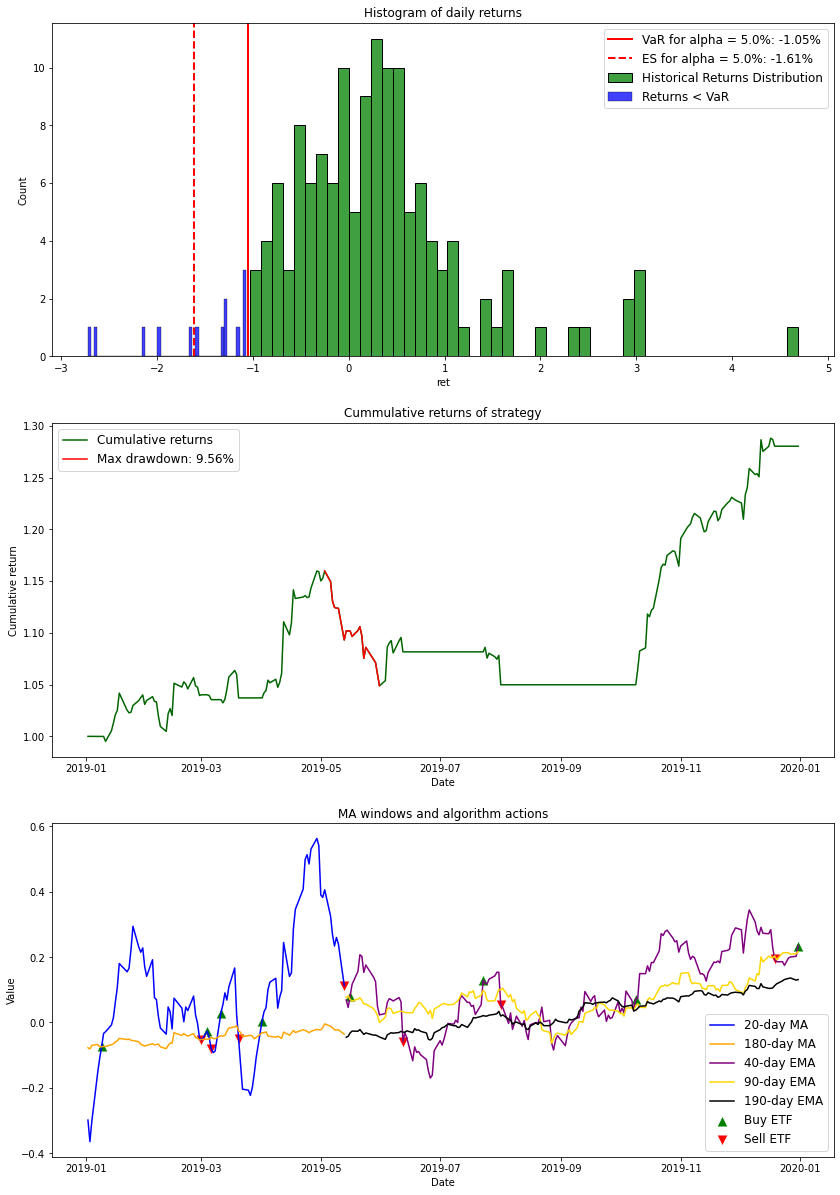

Sharpe ratio: 0.108
Rachev ratio: 1.113
Market beta: 0.388
Max drawdown (% from capital): 1.47%
Cumulative return: 128.02%
Cumulative return over Maximum Drawdown: 13.39


In [46]:
f_data, invs, cum_rets, cap, ratios = \
            RunMovingAverageCrossStrategyUpgraded(data, target, date1 = '2019-01-01', date2 = '2019-12-31',
                                                  short_window = 20, long_window = 180, 
                                                  fast_window = 40, medium_window = 90, slow_window=190, 
                                                  summa = 8 * 10**5, upgrade = False, 
                                                  up = 1, show_results = True, mode='MA')

### 2. upgrade -- True, mode -- MA

In [27]:
goods2, _, _ = RunTradingStrategies(data, target, upgrade = True, mode='MA')

Start: 2023-12-03 07:20:54.660517
Checking strategy num 100 ... Time: 2023-12-03 07:23:21.130080
Checking strategy num 200 ... Time: 2023-12-03 07:25:48.958891
Checking strategy num 300 ... Time: 2023-12-03 07:28:16.019766
Checking strategy num 400 ... Time: 2023-12-03 07:30:43.614173
Checking strategy num 500 ... Time: 2023-12-03 07:33:10.713892
Checking strategy num 600 ... Time: 2023-12-03 07:35:37.219818
Checking strategy num 700 ... Time: 2023-12-03 07:38:03.488517
Checking strategy num 800 ... Time: 2023-12-03 07:40:29.896312
Checking strategy num 900 ... Time: 2023-12-03 07:42:57.287496
Checking strategy num 1000 ... Time: 2023-12-03 07:45:25.733574
Checking strategy num 1100 ... Time: 2023-12-03 07:47:51.621711
Checking strategy num 1200 ... Time: 2023-12-03 07:50:16.968506
Checking strategy num 1300 ... Time: 2023-12-03 07:52:42.144690
Checking strategy num 1400 ... Time: 2023-12-03 07:55:07.238873
Checking strategy num 1500 ... Time: 2023-12-03 07:57:33.685640
Checking strate

Top 5:

In [28]:
[(k, v) for k, v in sorted(goods2.items(), key = lambda item: item[1][0])][::-1][:5]

[('800000, 40, 140, 40, 90, 190', [1.0893341902560914, 18.96448145924215]),
 ('800000, 40, 140, 40, 90, 170', [1.0893341902560914, 18.96448145924215]),
 ('800000, 40, 140, 40, 90, 150', [1.0893341902560914, 18.96448145924215]),
 ('800000, 40, 140, 40, 70, 190', [1.0893341902560914, 18.96448145924215]),
 ('800000, 40, 140, 40, 70, 170', [1.0893341902560914, 18.96448145924215])]

Look at the best one:

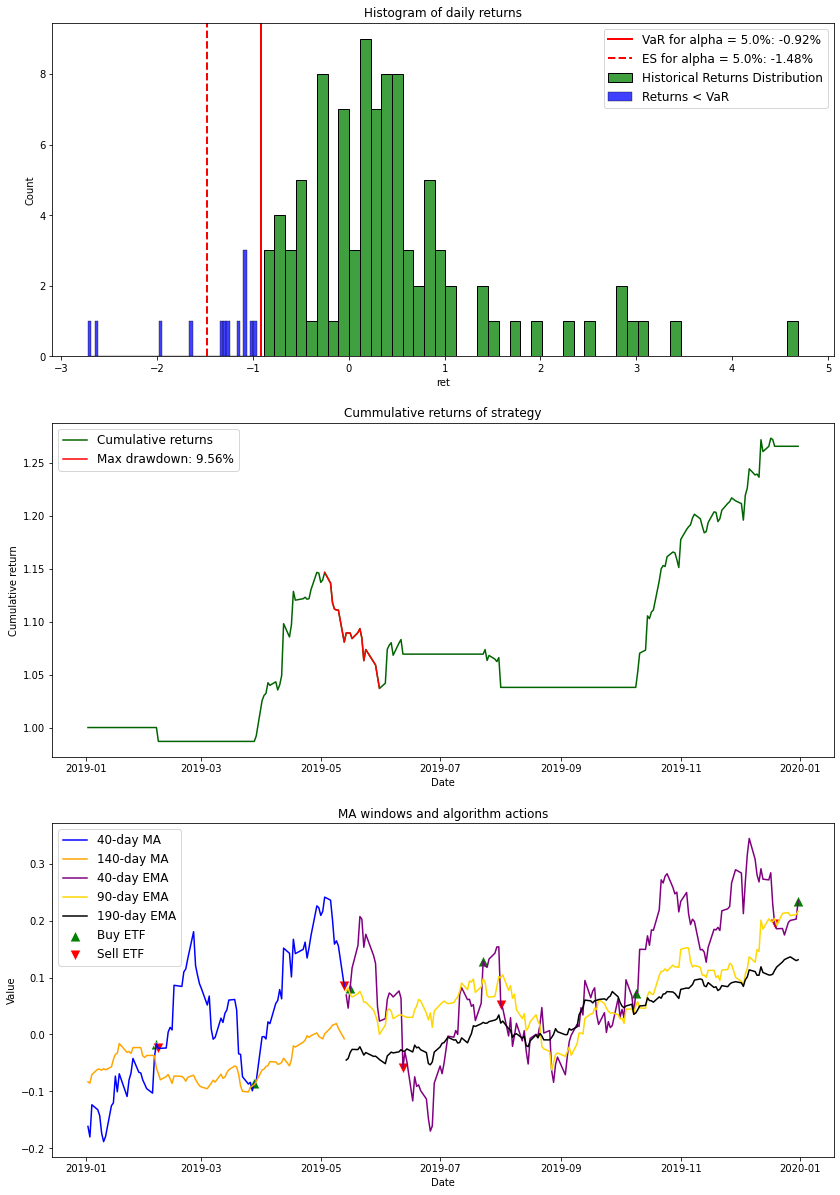

Sharpe ratio: 0.109
Rachev ratio: 1.145
Market beta: 0.334
Max drawdown (% from capital): 1.47%
Cumulative return: 126.57%
Cumulative return over Maximum Drawdown: 13.24


In [47]:
f_data, invs, cum_rets, cap, ratios = \
            RunMovingAverageCrossStrategyUpgraded(data, target, date1 = '2019-01-01', date2 = '2019-12-31',
                                                  short_window=40, long_window=140,
                                                  fast_window = 40, medium_window = 90, slow_window=190, 
                                                  summa = 8 * 10**5, upgrade = True, 
                                                  up = 1, show_results = True, mode='MA')

Also let's try the same thing with prices, using it like a benchmark (authors use exactly prices).

### 3. upgrade -- False, mode -- EMA

In [32]:
target = val_and_test.loc[:, 'standard_residuals']

In [34]:
goods3, _, _ = RunTradingStrategies(data, target, upgrade = False, mode='EMA')

Start: 2023-12-03 08:41:06.895746
Checking strategy num 100 ... Time: 2023-12-03 08:43:40.383570
Checking strategy num 200 ... Time: 2023-12-03 08:46:14.160318
Checking strategy num 300 ... Time: 2023-12-03 08:48:48.107242
Checking strategy num 400 ... Time: 2023-12-03 08:51:23.375598
Checking strategy num 500 ... Time: 2023-12-03 08:53:57.122003
Checking strategy num 600 ... Time: 2023-12-03 08:56:32.038455
Checking strategy num 700 ... Time: 2023-12-03 08:59:07.268662
Checking strategy num 800 ... Time: 2023-12-03 09:01:43.765546
Checking strategy num 900 ... Time: 2023-12-03 09:04:19.594071
Checking strategy num 1000 ... Time: 2023-12-03 09:06:54.889006
Checking strategy num 1100 ... Time: 2023-12-03 09:09:30.970895
Checking strategy num 1200 ... Time: 2023-12-03 09:12:05.143354
Checking strategy num 1300 ... Time: 2023-12-03 09:14:41.087119
Checking strategy num 1400 ... Time: 2023-12-03 09:17:15.688319
Checking strategy num 1500 ... Time: 2023-12-03 09:19:49.118878
Checking strate

Top 5:

In [35]:
[(k, v) for k, v in sorted(goods3.items(), key = lambda item: item[1][0])][::-1][:5]

[('800000, 20, 180, 9, 14, 24', [1.1017979932848565, 19.18146681007842]),
 ('800000, 20, 180, 9, 14, 22', [1.1017979932848565, 19.18146681007842]),
 ('800000, 20, 180, 9, 14, 20', [1.1017979932848565, 19.18146681007842]),
 ('800000, 20, 180, 9, 12, 24', [1.1017979932848565, 19.18146681007842]),
 ('800000, 20, 180, 9, 12, 22', [1.1017979932848565, 19.18146681007842])]

Look at the best one:

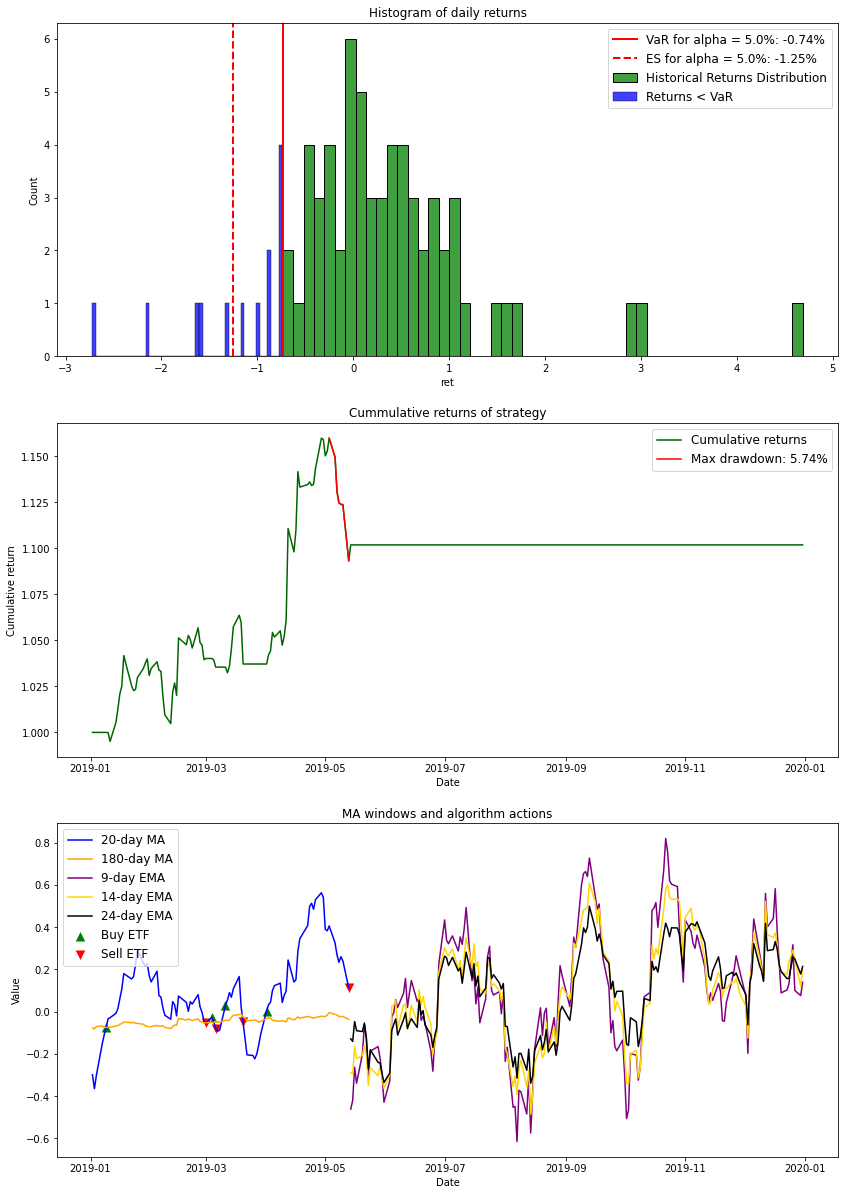

Sharpe ratio: 0.046
Rachev ratio: 0.923
Market beta: 0.183
Max drawdown (% from capital): 0.91%
Cumulative return: 110.18%
Cumulative return over Maximum Drawdown: 19.18


In [37]:
f_data, invs, cum_rets, cap, ratios = \
            RunMovingAverageCrossStrategyUpgraded(data, target, date1 = '2019-01-01', date2 = '2019-12-31', 
                                                  short_window = 20, long_window = 180, mode='EMA',
                                                  fast_window = 9, medium_window = 14, slow_window=24, 
                                                  summa = 8 * 10**5, upgrade = False, 
                                                  up = 1, show_results = True)

### 4. upgrade -- True, mode -- EMA

In [38]:
goods4, _, _ = RunTradingStrategies(data, target, upgrade = True, mode='EMA')

Start: 2023-12-03 09:51:38.050718
Checking strategy num 100 ... Time: 2023-12-03 09:54:12.199446
Checking strategy num 200 ... Time: 2023-12-03 09:56:47.544905
Checking strategy num 300 ... Time: 2023-12-03 09:59:22.324754
Checking strategy num 400 ... Time: 2023-12-03 10:01:56.939100
Checking strategy num 500 ... Time: 2023-12-03 10:04:32.290502
Checking strategy num 600 ... Time: 2023-12-03 10:07:08.014748
Checking strategy num 700 ... Time: 2023-12-03 10:09:43.858918
Checking strategy num 800 ... Time: 2023-12-03 10:12:18.612514
Checking strategy num 900 ... Time: 2023-12-03 10:14:53.237426
Checking strategy num 1000 ... Time: 2023-12-03 10:17:27.800645
Checking strategy num 1100 ... Time: 2023-12-03 10:20:01.982739
Checking strategy num 1200 ... Time: 2023-12-03 10:22:36.835435
Checking strategy num 1300 ... Time: 2023-12-03 10:25:11.628842
Checking strategy num 1400 ... Time: 2023-12-03 10:27:46.153263
Checking strategy num 1500 ... Time: 2023-12-03 10:30:20.499795
Checking strate

Top 5:

In [40]:
[(k, v) for k, v in sorted(goods4.items(), key = lambda item: item[1][0])][::-1][:5]

[('800000, 40, 140, 9, 14, 24', [1.0893341902560914, 18.96448145924215]),
 ('800000, 40, 140, 9, 14, 22', [1.0893341902560914, 18.96448145924215]),
 ('800000, 40, 140, 9, 14, 20', [1.0893341902560914, 18.96448145924215]),
 ('800000, 40, 140, 9, 12, 24', [1.0893341902560914, 18.96448145924215]),
 ('800000, 40, 140, 9, 12, 22', [1.0893341902560914, 18.96448145924215])]

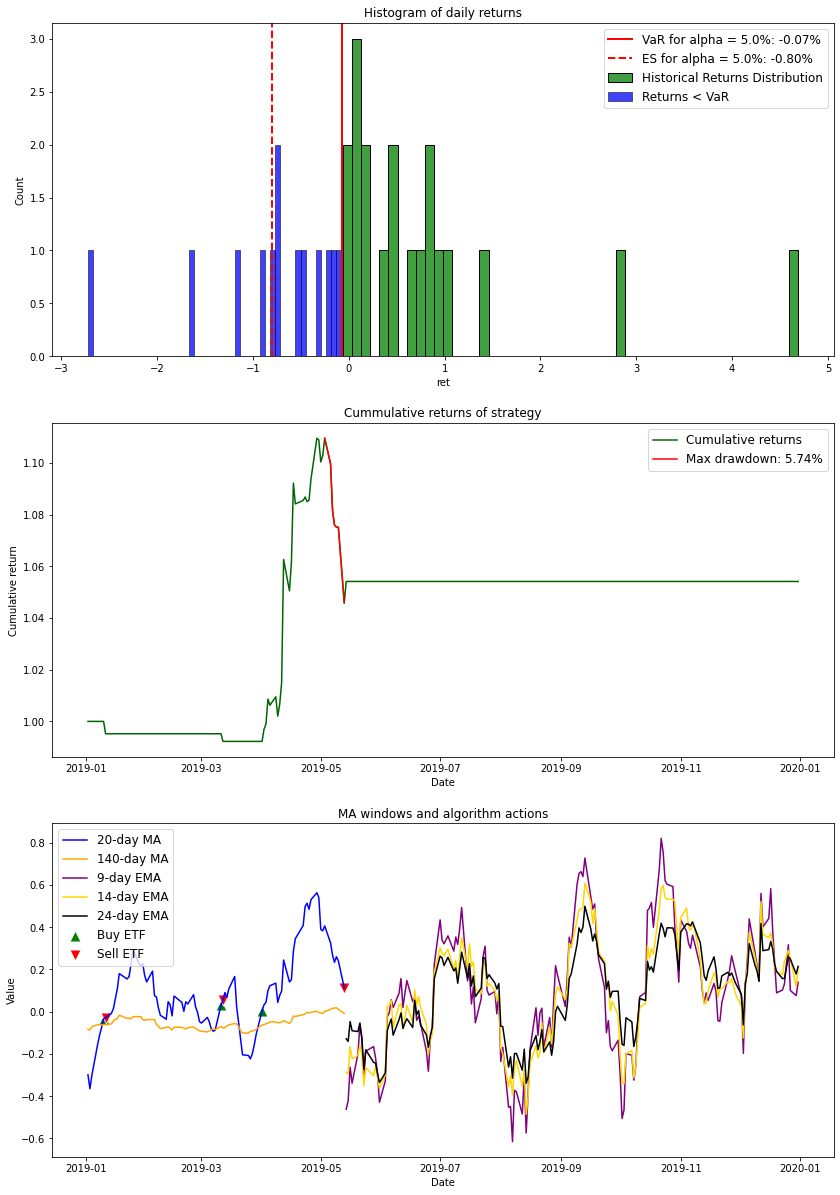

Sharpe ratio: 0.019
Rachev ratio: 1.176
Market beta: 0.096
Max drawdown (% from capital): 0.91%
Cumulative return: 105.41%
Cumulative return over Maximum Drawdown: 18.35


In [41]:
f_data, invs, cum_rets, cap, ratios = \
            RunMovingAverageCrossStrategyUpgraded(data, target, date1 = '2019-01-01', date2 = '2019-12-31', 
                                                  short_window = 20, long_window = 140, mode='EMA',
                                                  fast_window = 9, medium_window = 14, slow_window=24, 
                                                  summa = 8 * 10**5, upgrade = True, 
                                                  up = 1, show_results = True)

## Final battle

In [23]:
target = val_and_test.loc[:, 'standard_residuals']

### Train + validation data

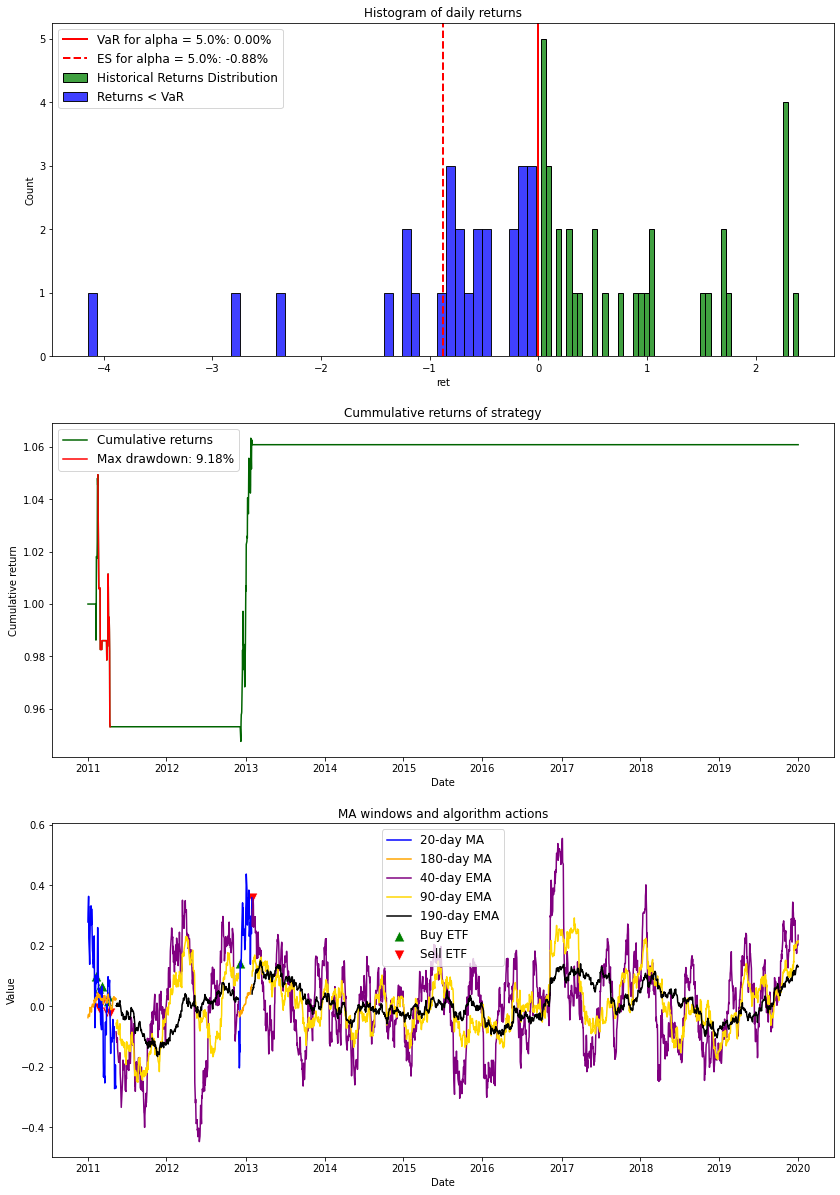

Sharpe ratio: -0.053
Rachev ratio: 1.007
Market beta: 0.019
Max drawdown (% from capital): 1.46%
Cumulative return: 106.09%
Cumulative return over Maximum Drawdown: 11.56


In [24]:
f_data, invs, cum_rets, cap, ratios = \
            RunMovingAverageCrossStrategyUpgraded(data, target, date1 = '2011-01-01', date2 = '2019-12-31', 
                                                  short_window = 20, long_window = 180, 
                                                  fast_window = 40, medium_window = 90, slow_window=190, 
                                                  summa = 8 * 10**5, upgrade = False, 
                                                  up = 1, show_results = True, mode='MA')

### Test data

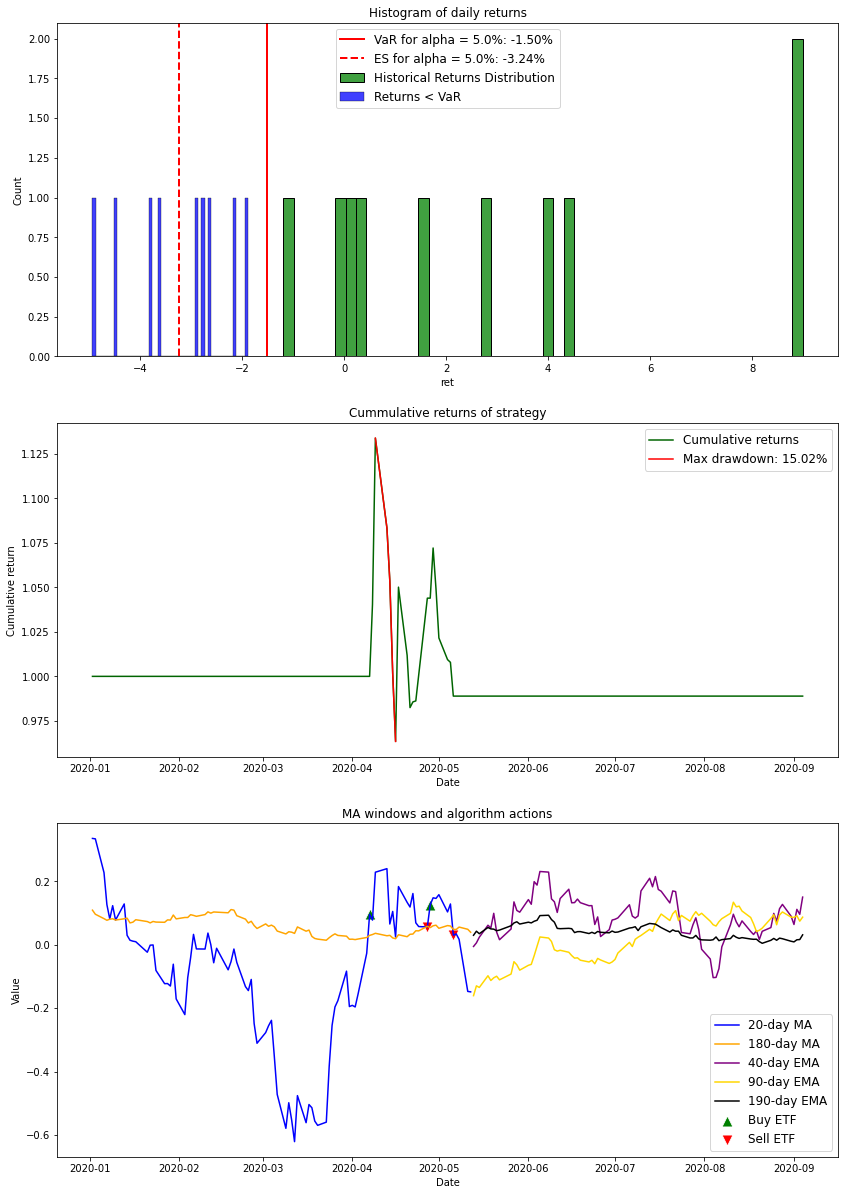

Sharpe ratio: -0.008
Rachev ratio: 1.192
Market beta: 0.090
Max drawdown (% from capital): 2.41%
Cumulative return: 98.89%
Cumulative return over Maximum Drawdown: 6.59


In [25]:
f_data, invs, cum_rets, cap, ratios = \
            RunMovingAverageCrossStrategyUpgraded(data, target, date1 = '2020-01-01', date2 = '2020-09-04', 
                                                  short_window = 20, long_window = 180, 
                                                  fast_window = 40, medium_window = 90, slow_window=190, 
                                                  summa = 8 * 10**5, upgrade = False, 
                                                  up = 1, show_results = True, mode='MA')

In [26]:
print(f'Number of transactions (open and close positions): {len(invs)}')

Number of transactions (open and close positions): 4


In [27]:
print('Return on investment: ' + str(round((cap - 5 * 10**6) / (8 * 10**5) * 100, 2)) + '%')

Return on investment: -1.28%


In [28]:
print('Return in % from capital: ' + str(round((cap / (5 * 10**6) - 1) * 100, 2)) + '%')

Return in % from capital: -0.2%
